## Tile-based KLT tracker

image size (w, h):  752 480
Tile (y,x): 0 0
New corners detected: 35
Total corners (35, 1, 2)
Tile (y,x): 0 100
New corners detected: 50
Total corners (85, 1, 2)
Tile (y,x): 0 200
New corners detected: 50
Total corners (135, 1, 2)
Tile (y,x): 0 300
New corners detected: 50
Total corners (185, 1, 2)
Tile (y,x): 0 400
New corners detected: 50
Total corners (235, 1, 2)
Tile (y,x): 0 500
New corners detected: 50
Total corners (285, 1, 2)
Tile (y,x): 0 600
New corners detected: 45
Total corners (330, 1, 2)
Tile (y,x): 0 700
New corners detected: 9
Total corners (339, 1, 2)
Tile (y,x): 100 0
New corners detected: 46
Total corners (385, 1, 2)
Tile (y,x): 100 100
New corners detected: 50
Total corners (435, 1, 2)
Tile (y,x): 100 200
New corners detected: 50
Total corners (485, 1, 2)
Tile (y,x): 100 300
New corners detected: 50
Total corners (535, 1, 2)
Tile (y,x): 100 400
New corners detected: 50
Total corners (585, 1, 2)
Tile (y,x): 100 500
New corners detected: 50
Total corners (635, 1, 2)
T

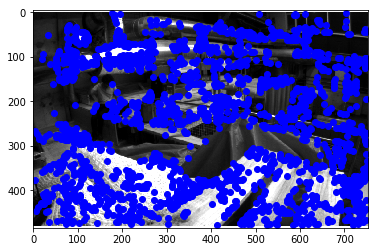

Frame  1 :
Clean up step 1 (fwd bwd consistency): 	feature_list.shape: (1914, 4)
Clean up step 2 (mininum distance): 	feature_list.shape: (1914, 4)
Clean up step 3 (img boundary check): 	feature_list.shape: (1910, 4)
feature_list.shape:  (1910, 4)
TileAffineSolver at tile: ( 0 0 )
Shape A: (35, 4)
Shape B, C for Bx=C: (70, 4) (70,)
Ransac inliers_idx of B =  [44  1 33 11 65  6 19  9  4 42 57 59 36 45 55 23  2 21 30 31 43  7 32 18 26
 28 63 25 49 37  0 62 20  3  5 53 16 39 41 22 15 13 40 67 17 12 35 38 61 27
 47 51 10 24 29 58 69]
[[ 1.00213945]
 [ 0.9951458 ]
 [-2.31287169]
 [-0.37771168]] min_err =  0.0102269 inliers =  57   81.42857142857143 %
TileAffineSolver at tile: ( 0 100 )
Shape A: (50, 4)
Shape B, C for Bx=C: (100, 4) (100,)
Ransac inliers_idx of B =  [24 44 30 37 35 10  2 92 39 52 12 70 71 26 13 53 54 56 23  5 14 84 58 36 61
 90 95 81 67 51  0  4 41 93 45 34 31  9  6 43  7 18 65 49 29 97 62 96 28 73
 60 68 88 83 22 82 59 80  8 74 21 46 78 19 57  3 11  1 42 79 15 75 87 91 63
 

Ransac inliers_idx of B =  [20 11 42 14 73 93 88  2  8 43 92 16 44 48 75 26 27 82 87 40 84 99  9 64  0
 66 80 51 50  4 46 23 86 58 97 62 39 77 17 15 60 61 85 56 67 96 28 52 54 90
 36 10 18 76 83 79  5 69  6 13 21 95  1 78 91 34 32 35 41 57  7 71 68 98 45
 30 25 31 33 47 55 38 49 89 74 22 65 29  3 70 12 24 19 53 81 37 72 94 63 59]
[[ 1.00182402]
 [ 0.99577808]
 [-3.08386421]
 [ 0.24864046]] min_err =  0.0109496 inliers =  100   100.0 %
TileAffineSolver at tile: ( 200 300 )
Shape A: (50, 4)
Shape B, C for Bx=C: (100, 4) (100,)
Ransac inliers_idx of B =  [93 64 39 23 82 19 37 75 49 65  1 63 77 85 32 71 15  7 61 87 11 59 70 34 17
  8 78 99 80 21 26 69 73 31 66 53 51 74 43 36 86 97 41 98 35 25 55 47 89 95
 44  3 29 91 81 83 18 68 24 92 76 45 67  5 58 62 13 79  9 33 10 27 84 57 88
 54 42]
[[ 1.00221705]
 [ 0.99917245]
 [-3.22609138]
 [-0.73864532]] min_err =  0.0239084 inliers =  77   77.0 %
TileAffineSolver at tile: ( 200 400 )
Shape A: (50, 4)
Shape B, C for Bx=C: (100, 4) (100,)
Ransac in

Ransac inliers_idx of B =  [20 47 43 31 34 21 50 46 36 55 37 24 18 84 22 73 89 17 39 74 38 71 94  8 92
 70 96 12 15 35 64 87 79 54 80 69  1  9 61  6 72 75 66 10 14 93 65 30 63 28
 95 11 86 68 58 25 44 88 16 52 13 26 51 42 76 78 83 56 77 62 60 57 41 53 59
 40  0 98 82 67 27 45  4]
[[ 1.00212216]
 [ 0.99275863]
 [-1.39755535]
 [-3.44903994]] min_err =  0.344778 inliers =  83   83.0 %
TileAffineSolver at tile: ( 400 600 )
Shape A: (50, 4)
Shape B, C for Bx=C: (100, 4) (100,)
Ransac inliers_idx of B =  [51 37 62 73 53 81 91  3 27 94 71 76 43 11 99 87 75 15 57 89 33 39 24 67  5
 83 29 93 35 17 18 79 55 95 65  7 49 97 85 41 77 25 69 10 19 23 47  1 59 21
 61 45 31  9 13 63]
[[  0.90071362]
 [  0.99258423]
 [ 61.10455322]
 [ -3.18305469]] min_err =  0.0718728 inliers =  56   56.00000000000001 %
TileAffineSolver at tile: ( 400 700 )
Shape A: (50, 4)
Shape B, C for Bx=C: (100, 4) (100,)
Ransac inliers_idx of B =  [86 51 75 92 54 65 81 55 77 93 98 14 37 35  9 89 15 99 95 63 32 39 17 61 49
 53 47 

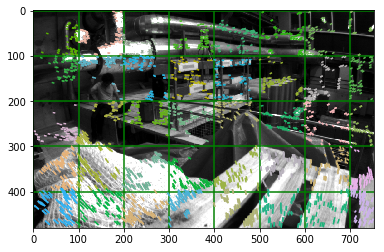

Frame  2 :
Clean up step 1 (fwd bwd consistency): 	feature_list.shape: (1914, 4)
Clean up step 2 (mininum distance): 	feature_list.shape: (1914, 4)
Clean up step 3 (img boundary check): 	feature_list.shape: (1906, 4)
feature_list.shape:  (1906, 4)
TileAffineSolver at tile: ( 0 0 )
Shape A: (35, 4)
Shape B, C for Bx=C: (70, 4) (70,)
Ransac inliers_idx of B =  [24  7 13 28 17 63 19 57 11 29 51 43 10 14 35 26 44 33  3 32 18 15 69 53 61
 16 12 59 34 37 39  2 36  4 55 56  0 27 52 46 31 42 40 60 54  9 64 41 22 66
 45  8 21 20 30 58 50 38  5  6 25 23  1 65 49 67 62 47]
[[ 1.00407052]
 [ 0.99260175]
 [-1.91537118]
 [-4.03628635]] min_err =  0.013621 inliers =  68   97.14285714285714 %
TileAffineSolver at tile: ( 0 100 )
Shape A: (50, 4)
Shape B, C for Bx=C: (100, 4) (100,)
Ransac inliers_idx of B =  [91 19 81 65 68 28 95 43  3 99  0 60 78 88 53 69 16 73 63 31 37 76 20 36 84
 35 74 77 39 59 75 34 42 49 83 87 50 47 45 71 32  6  5 29 17 58 94 21 61 51
  9 55 41 56  7 90 14 62  8 27 57  2 67 15 93

Ransac inliers_idx of B =  [ 62  76  78  26  96   5  71  18  82  32  70  28  38  64  19  54   6   2
  34  98  79  66  60  97  74  44  14   0  40  86   8  10  68  29  30  94
  50  80  83  16  90 100  12  20  24  46  65  25  52  84  92  42  43  72
  48  58  56   4  88  22  36]
[[ 1.00196636]
 [ 0.9825201 ]
 [-2.64783216]
 [-0.53063846]] min_err =  0.00634442 inliers =  61   59.80392156862745 %
TileAffineSolver at tile: ( 200 300 )
Shape A: (47, 4)
Shape B, C for Bx=C: (94, 4) (94,)
Ransac inliers_idx of B =  [16 18 89 43  3 69 73 67 27 21 36  9 93 17 63 32 85 44 61 20 10 31 57 45 83
 38 91 64 60 12  1 50  8  2 26  4 56  5 88 71 81 84 30 39 92 54 35 40 77 11
 70 75 55 24 58 79 53  6 86 14 42 49 46 52 65 78 90 82 47 87 37 59 15 62 13
 25 22 51  7 33 74 29 34 41 23 19 68 76 72 66  0 80 28]
[[ 1.00553834]
 [ 0.99852729]
 [-3.803092  ]
 [-4.55727959]] min_err =  0.0339763 inliers =  93   98.93617021276596 %
TileAffineSolver at tile: ( 200 400 )
Shape A: (52, 4)
Shape B, C for Bx=C: (104, 4) (

Ransac inliers_idx of B =  [28 20 56 66 26 12 49 38 70 75 62 48 61 74 22 29 33  9 44 57  8 32 50 72 14
 37 60 15 23 17 46 64 27 30 36 42 63 16  0 39 78 40 45  6 69 18  5 43 52 53
  1 34 54 13  2 58 51 76  4 68 19 35 10 31 11]
[[ 1.01238024]
 [ 0.98646641]
 [-7.20066977]
 [-4.84909868]] min_err =  0.0749451 inliers =  65   81.25 %
TileAffineSolver at tile: ( 400 400 )
Shape A: (44, 4)
Shape B, C for Bx=C: (88, 4) (88,)
Ransac inliers_idx of B =  [10 52 31 44 75 14 22 60 17 73 47  9 50 11 26 82 16 67 66 71 24  6 57 46 29
 56 41 45 83 13 32 58 79 84 72 53 85 70 68 78 62 21 51 61 27 23 49 40  3  5
 33 20 34 42 64 15  7 65 48 59 87 43 37 35 69  2  8 86 25 30  4 63 36 12 74
 39 38]
[[  1.01944315]
 [  1.00184727]
 [ -9.66257095]
 [-13.80201721]] min_err =  0.0340331 inliers =  77   87.5 %
TileAffineSolver at tile: ( 400 500 )
Shape A: (48, 4)
Shape B, C for Bx=C: (96, 4) (96,)
Ransac inliers_idx of B =  [10 51 57 88  0 69 23 89 55 46 75 70 37  9 47 73  1 49 90 54 64 48 67 11 85
 20 52 83 30 

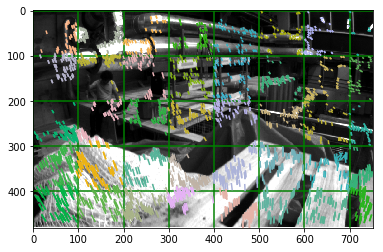

In [1]:
import cv2
import numpy as np
import scipy 
import scipy.linalg 
import pykitti
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import glob

# Local scripts
import tile_of_func as of


#-------------
# Global Parameters
#-------------
## Interactive mode - show image of every frame interactively.
INTERACTIVE = True


# Dataset location
# Change this to the directory where you store KITTI data
#basedir = '/work/git_repo/kitti_dataset_explore'
basedir = '/work/asl_dataset/ijrr_euroc_mav_dataset/machine_hall/MH_01_easy/mav0/cam0/data'


# Tile size
tile_size = 100

# List of camera data
cam0_img_list = np.sort(glob.glob(basedir+'/*.png'))

# No of frames to process
frame_range = range(0, 3, 1)

#-------------
# Main(): Processing cam
#-------------

for fr in frame_range:
    #Pyplot figure size
    plt.figure(figsize=(12,4))
    plt.autoscale(tight=True)

    cam0 = cv2.imread(cam0_img_list[fr], cv2.IMREAD_GRAYSCALE)
    plt.imshow(cam0,cmap='gray')

    # Optical flow tracking
    # Feature list for consistency check
    feature_list = []

    # First frame, mark feature
    if fr==0:

        (cam0_height, cam0_width) = cam0.shape
        print("image size (w, h): ", cam0_width, cam0_height)

        # Split image into tile_size to find features
        p0 = of.OF_TileFindFeature(cam0, tile_size, of.feature_params)
        #DEBUG print(p0.shape, p0)
        plt.scatter(p0[:,:,0], p0[:,:,1], marker='o', color='b')

    # Optical flow tracking
    else:


        print("Frame ", fr, ":")
        # Forward OF tracking
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_cam0, cam0, p0, None, **of.lk_params)

        good_old = p0[st==1]
        good_new = p1[st==1]

        # Backward OF tracking
        p2, st2, err = cv2.calcOpticalFlowPyrLK(cam0, old_cam0, p1, None, **of.lk_params)

        # Clean-up feature_list
        feature_list = of.OF_FeatureListFilter(p0, p1, p2, cam0_width, cam0_height)

#        # Draw filtered feature points and associated OF
#        for idx in range(feature_list.shape[0]):
#            plt.plot([feature_list[idx,0], feature_list[idx,2]], 
#                            [feature_list[idx,1], feature_list[idx,3]],
#                            linestyle='-', color='plum')

#        # Draw old feature points
#        #plt.scatter(good_old[:,0], good_old[:,1], marker='^', c='g')
#        # Draw new feature points
#        #plt.scatter(good_new[:,0], good_new[:,1], marker='o', c='r')
#        # Draw optical flow
#        for idx in range(good_old.shape[0]):
#            plt.plot([good_old[idx,0], good_new[idx,0]], 
#                            [good_old[idx,1], good_new[idx,1]],
#                            linestyle='-', color='b')

        # Find affine parameters sx,sy,tx,ty for each grid
        of.OF_TileAffineSolver(cam0, tile_size, feature_list)

        # Save points for next round
        p0 = good_new.reshape(-1,1,2)



    old_cam0 = cam0.copy()

    # Save pyplot image
    plt.savefig(str(fr).zfill(3)+'_of.png')
    # Show the OF tracking image
    if INTERACTIVE:
        plt.show()
    
        ## Use opencv to show image
        #cv2.imshow('cam0',cam0)
        #k = cv2.waitKey(-1)
        #cv2.destroyAllWindows()

## Frame-level KLT tracker

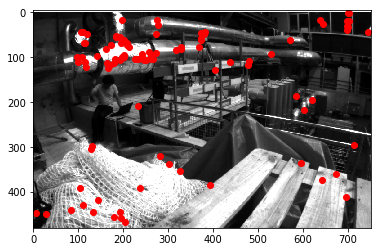

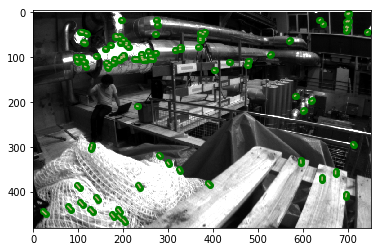

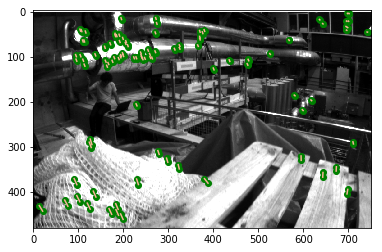

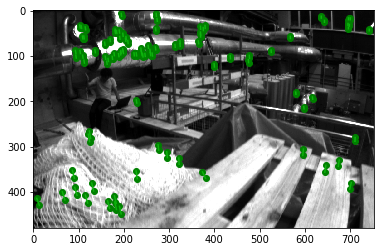

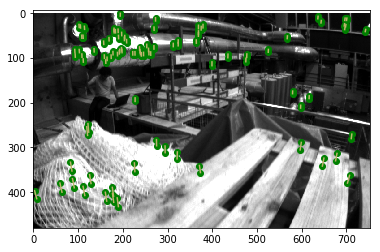

In [2]:
import cv2
import numpy as np
import pykitti
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#-------------
# Dataset location
#-------------
# Change this to the directory where you store KITTI data
basedir = '/work/asl_dataset/ijrr_euroc_mav_dataset/machine_hall/MH_01_easy/mav0/cam0/data'


#-------------
# Optical Flow related setting
#-------------
# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.01,
                       minDistance = 3,
                       blockSize = 3)
 
# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15,15),
                  maxLevel = 4,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# List of camera data
cam0_img_list = np.sort(glob.glob(basedir+'/*.png'))

# No of frames to process
frame_range = range(0, 5, 1)

#-------------
# Processing cam
#-------------

for fr in frame_range:
    #Pyplot figure size
    plt.figure(figsize=(12,4))
    plt.autoscale(tight=True)

    cam0 = cv2.imread(cam0_img_list[fr], cv2.IMREAD_GRAYSCALE)
    
    # Show the gray img from camera 0
    plt.imshow(cam0, cmap='gray')
    

    # Optical flow tracking
    # First frame, mark feature
    if fr==0:
        p0 = cv2.goodFeaturesToTrack(cam0, mask = None, **feature_params)
        plt.scatter(p0[:,:,0], p0[:,:,1], marker='o', color='r')
    # Draw flow
    else:
        # OF tracking
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_cam0, cam0, p0, None, **lk_params)

        good_old = p0[st==1]
        good_new = p1[st==1]

        plt.scatter(good_old[:,0], good_old[:,1], linestyle='-', c='g')
        plt.scatter(good_new[:,0], good_new[:,1], linestyle='-', c='g')
        cur_rand_color = (np.random.rand(),0.7, np.random.rand(),1.0)

        for idx in range(good_old.shape[0]):
            plt.plot([good_old[idx,0], good_new[idx,0]], 
                            [good_old[idx,1], good_new[idx,1]],
                            linestyle='-', color=cur_rand_color)

        p0 = good_new.reshape(-1,1,2)

    old_cam0 = cam0.copy()

    # Save pyplot image
    plt.savefig(str(fr).zfill(3)+'.png')
    # Show the image
    plt.show()
    
    # Use opencv to show image
    #cv2.imshow('cam0',cam0)
    #k = cv2.waitKey(-1)
    #cv2.destroyAllWindows()

## Camera distortion correction

Use page: https://hackaday.io/project/12384-autofan-automated-control-of-air-flow/log/41862-correcting-for-lens-distortions

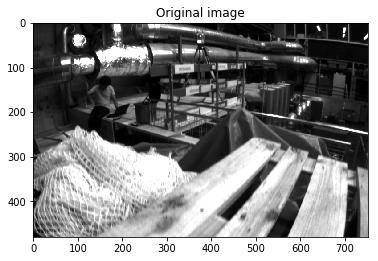

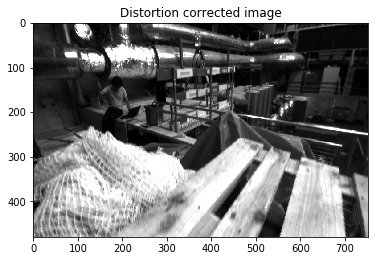

In [25]:

# K - intrinsics
K = np.array([
    [458.654, 0., 367.215],
    [0., 457.296, 248.375],
    [0., 0., 1.]
])

# D - distortion coefficients
D = np.array([-0.28340811, 0.07395907, 0.00019359, 1.76187114e-05, 0.])

h, w = cam0.shape

# Generate new camera matrix from parameters
newcameramatrix, roi = cv2.getOptimalNewCameraMatrix(K, D, (w,h), 0)

# Generate look-up tables for remapping the camera image
mapx, mapy = cv2.initUndistortRectifyMap(K, D, None, newcameramatrix, (w, h), 5)

# Remap the original image to a new image
#new_cam0 = cv2.remap(cam0, mapx, mapy, cv2.INTER_LINEAR)
new_cam0 = cv2.remap(cam0, mapx, mapy, cv2.INTER_LINEAR, cv2.BORDER_TRANSPARENT, 0)

# Display old and new image

plt.imshow(cam0, cmap='gray')
plt.title('Original image')
plt.show()
plt.imshow(new_cam0, cmap='gray')
plt.title('Distortion corrected image')
plt.show()


## Trajectory drawing

Useful page: https://matplotlib.org/examples/mplot3d/lines3d_demo.html
